In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

from fastai.data_block import DataBunch, DatasetType
from fastai.basics import Learner

%matplotlib inline

## Yearly Seasonality

0.0
0.0
-7.786769706960002e-17
-7.786769706960002e-17


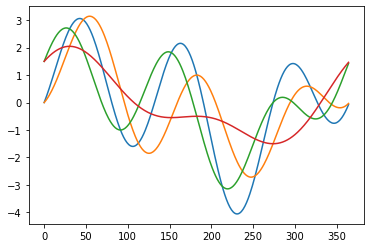

In [2]:
P = 365
N = 365
t = np.arange(N)

# Coefficients
ans = [[1, 0.5, -1.5], [1, 0.5, 0]]
bns = [[1, -0.5, 1.5], [1, 0.5, 0]]

for an in ans:
    for bn in bns:
        s = [a*np.cos(2*np.pi*(n+1)*t/P) + b*np.sin(2*np.pi*(n+1)*t/P)
             for n,(a,b) in enumerate(zip(an, bn))]
        y = sum(s)
        print(y.mean())

        plt.plot(t, y)
plt.show()

## Generate Monthly Trend + Yearly

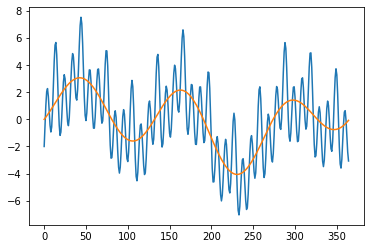

In [3]:
P = 365
P2 = 30.5
N = 365
t = np.arange(N)

# Coefficients
an = [1, 0.5, -1.5]
bn = [1, -0.5, 1.5]

an2 = [-1, 0.5, -1.5]
bn2 = [1, -0.5, 2]

s = [a*np.cos(2*np.pi*(n+1)*t/P) + b*np.sin(2*np.pi*(n+1)*t/P)
     for n,(a,b) in enumerate(zip(an, bn))]
s2 = [a*np.cos(2*np.pi*(n+1)*t/P2) + b*np.sin(2*np.pi*(n+1)*t/P2)
     for n,(a,b) in enumerate(zip(an2, bn2))]

y = sum(s) + sum(s2)

plt.plot(t, y)
plt.plot(t, sum(s))
plt.show()

In [4]:
class TimeSeries(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return torch.Tensor([self.x[i]]), torch.Tensor([self.y[i]])

In [5]:
train_len = int(0.8*len(y))
train_ds = TimeSeries(t[:train_len], y[:train_len])
test_ds = TimeSeries(t[train_len:], y[train_len:])
bs = 96
db = DataBunch.create(train_ds, test_ds, bs=bs)

In [6]:
class FourierModel(nn.Module):
    def __init__(self, y_n=7, m_n=5, w_n=0, 
                 P1=365.25, P2=30.5, P3=7):
        super().__init__()
        self.y_n, self.m_n, self.w_n = y_n, m_n, w_n
        np = [(n+1, P1) for n in range(y_n)]
        np += [(n+1, P2) for n in range(m_n)]
        np += [(n+1, P3) for n in range(w_n)]
        self.np = np
        self.linear = nn.Linear(2*len(np), 1, bias=False)
        
    def forward(self, x):
        cos = [torch.cos(2*np.pi*n*x/p) for n,p in self.np]
        sin = [torch.sin(2*np.pi*n*x/p) for n,p in self.np]
        x = torch.cat(cos + sin, dim=1)
                
        return self.linear(x)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


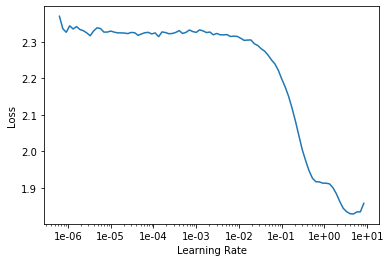

In [7]:
model = FourierModel()
learner = Learner(db, model, loss_func=F.l1_loss)
wd = 0
learner.lr_find(wd=wd)
learner.recorder.plot(skip_end=0)

In [8]:
epochs = 20
learner.fit_one_cycle(epochs, 2e-1, wd=wd)

epoch,train_loss,valid_loss,time
0,2.315535,1.595589,00:00
1,2.275074,1.524760,00:00
2,2.184779,1.394441,00:00
3,2.044564,1.266881,00:00
4,1.843260,1.311349,00:00
5,1.593967,1.363664,00:00
6,1.384988,1.258048,00:00
7,1.241531,1.069199,00:00
8,1.118658,0.852622,00:00
9,1.003905,0.716648,00:00


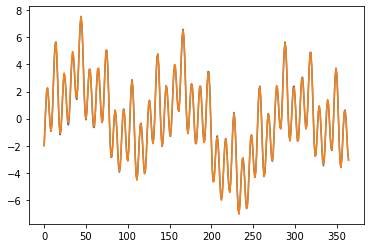

In [10]:
y2 = learner.model(torch.Tensor(t)[:,None])
plt.plot(t, y)
plt.plot(t, y2.detach().cpu().numpy().squeeze())
plt.show()

In [30]:
weights = list(learner.model.parameters())
weights = weights[0].detach().cpu().numpy().squeeze()
an_weights = weights[[0,1,2,7,8,9]]
bn_weights = weights[[12,13,14,19,20,21]]

In [31]:
print('Actual: ', an + an2)
print('Estimated: ', an_weights)

Actual:  [1, 0.5, -1.5, -1, 0.5, -1.5]
Estimated:  [ 1.03115   0.50228  -1.482039 -0.979939  0.504212 -1.479925]


In [32]:
print('Actual: ', bn + bn2)
print('Estimated: ', bn_weights)

Actual:  [1, -0.5, 1.5, 1, -0.5, 2]
Estimated:  [ 1.018327 -0.487524  1.529174  1.003532 -0.498676  1.989461]
